
Viscoplastic thermal convection in a 2-D square box
=======

Benchmarks from Tosi et al. 2015
--------



This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) in Underworld2. The Underworld2 results are compared to the model run on Fenics. Input files for the Fenics models were provided by Petra Maierova.

This example uses the RT PIC solver with classic and nearest neighbour


References
====

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pyplot as pyplot
import time
import numpy as np
import os

Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [2]:
RA  = 1e2        # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA_T = 1e5
ETA_Y = 10
ETA0 = 1e-3
TMAX = 3.0
IMAX = 1000

Simulation parameters. Resolution in the horizontal (*Xres*) and vertical (*Yres*) directions.

In [3]:
Xres, Yres = 40, 40
dim = 2          # number of spatial dimensions

Select which case of viscosity from Tosi et al (2015) to use. Adjust the yield stress to be =1 for cases 1-4, or between 3.0 and 5.0 (in increments of 0.1) in case 5.

In [4]:
CASE = 2 # select identifier of the testing case (1-5)

if(CASE<5):
    YSTRESS = 1.0
else:
    YSTRESS = 3.0

Set output file and directory for results

In [5]:
outputPath = 'TosiOutput/'
imagePath = 'TosiOutput/images'
outputFile = 'results' + str(CASE) + '.dat'

# make directories if they don't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
if not os.path.isdir(imagePath):
    os.makedirs(imagePath)

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [6]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [7]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Create some dummy fevariables for doing top and bottom boundary calculations.

In [8]:
topField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
bottomField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)

topField.data[:] = 0.
bottomField.data[:] = 0.

# lets ensure temp boundaries are still what we want 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    bottomField.data[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    topField.data[index] = 1.

#ICs and BCs

In [9]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    

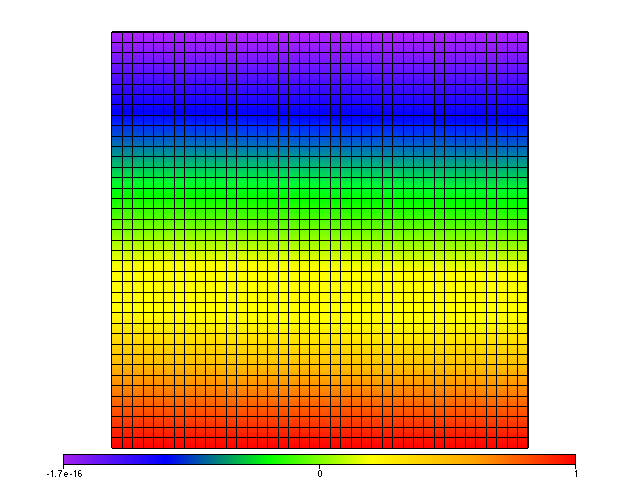

In [10]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, elementMesh)
figtemp.Mesh(linearMesh)
figtemp.show()

In [11]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [12]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [13]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [14]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

#Material properties


In [15]:
#Make variables required for plasticity

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))


In [16]:
coordinate = fn.input()

In [17]:
#Remember to use floats everywhere when setting up functions

#Linear viscosities
viscosityl1 = fn.math.exp(math.log(ETA_T)*-1*temperatureField)

viscosityl2 = fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

viscosityFn1 = viscosityl1 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


if CASE == 1:
    viscosityFn2 = viscosityFn1
elif CASE == 2:
    viscosityFn2 = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    viscosityFn2 = viscosityl2
else:
    viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


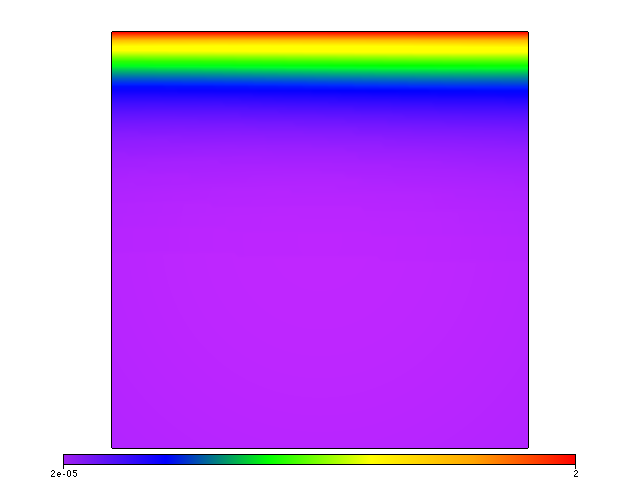

In [18]:
figEta = plt.Figure()
figEta.Surface(viscosityFn2, linearMesh)
figEta.show()

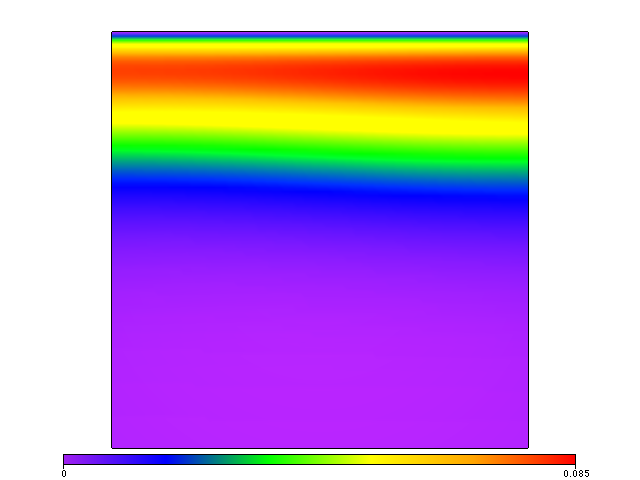

In [19]:
# lets take a look at the eta function
figEta = plt.Figure()
figEta.Surface(viscosityl2 - viscosityl1, linearMesh)
figEta.show()

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [20]:
densityFn = RA*temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = densityFn * z_hat

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [21]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              viscosityFn=fn.exception.SafeMaths(viscosityFn1), 
                              bodyForceFn=buoyancyFn)

We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [22]:
stokesPIC.solve()

In [23]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn2), 
                              bodyForceFn=buoyancyFn )

In [24]:
solver = uw.systems.Solver(stokesPIC) # altered from PIC2

Solve for initial pressure and velocity using a quick non-linear Picard iteration


In [25]:
solver.solve(nonLinearIterate=True)

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [26]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )


Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [27]:
def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

def nuss():
    nt = []
    nb = []
    grad = temperatureField.gradientFn 
    gradarray = grad.evaluate(linearMesh)
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        nt.append(gradarray[index][1]*(1./Xres))
    for index in linearMesh.specialSets["MinJ_VertexSet"]:
        nb.append(gradarray[index][1]*(1./Xres))
    n1 = sum(nt)
    n0 = sum(nb)
    return abs(n1), abs(n0)
    
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def rms_surf():
    xvelocityField = fn.math.dot(velocityField,np.array([1.,0.]))
    squared = uw.utils.Integral(fn.math.dot(topField, fn.math.dot(xvelocityField,xvelocityField)), linearMesh)
    toparea = uw.utils.Integral((topField*1.),linearMesh)
    return math.sqrt(squared.integrate()[0]/toparea.integrate()[0])

def max_vx_surf():
    surf_vels =[]
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        surf_vels.append(velocityField.data[index][0])
    return max(surf_vels)

def gravwork():
    dw = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)
    return dw.integrate()[0]

#note that viscosityFn2 is used here, so this is not case independent. 
def viscdis():
    secinv = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
    sinner = fn.math.dot(secinv,secinv)
    vd = uw.utils.Integral((4.*viscosityFn2*sinner), linearMesh)
    return vd.integrate()[0]

def visc_extr():
    testfn = fn.view.min_max(viscosityFn2)
    #evaluate on the mesh
    testfn.evaluate(linearMesh) 
    vmax, vmin = testfn.max_global(), testfn.min_global()
    return vmax, vmin


Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [28]:
realtime = 0.
step = 0
timevals = [0.]
vrmsvals = []
steps_end = 10
steps_output = 50
steps_outtoscreen = 50
steps_outtoscreen = max(steps_outtoscreen,1)
steps_output = min(steps_output,steps_end/10)
steps_output = max(steps_output,1)

In [29]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
f_o = open(outputPath+outputFile, 'w')
# Perform steps
while step < steps_end:
    #Enter non-linear loop
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    # Calculate the Metrics
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf()
    Gravwork = gravwork()
    Viscdis = viscdis()
    nu1, nu0 = nuss()
    etamax, etamin = visc_extr()
    # output to summary text file
    f_o.write((11*'%-15s ' + '\n') % (realtime, Viscdis, nu0, nu1, Avg_temp, Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin))
    # output image to file
    if step % steps_output == 0:
        print 'step =',step, 'Rms =', Rms, 'Nu bottom', nu0, 'Nu top', nu1
        ##Image
        field = temperatureField
        fig = pyplot.figure()
        ax = fig.add_subplot(1, 1, 1)
        image = np.reshape(field.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
        i = ax.imshow(np.flipud(image), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.])
        ax.contourf(image, cmap='coolwarm', extent=[0., 1., 0., 1.])
        fig.colorbar(i)
        fname = "temperatureField" + "_" + str(CASE) + "_" + str(step) + ".png"
        fullpath = os.path.join(outputPath + "images/" + fname)
        fig.savefig(fullpath, facecolor='0.95')
f_o.close()

step = 1 Rms = 6.34883035172 Nu bottom 1.025 Nu top 1.025
step = 2 Rms = 6.34883035172 Nu bottom 1.02549730728 Nu top 1.02500194426
step = 3 Rms = 7.53743363436 Nu bottom 1.02619770668 Nu top 1.02500391762
step = 4 Rms = 8.8262574528 Nu bottom 1.0271568113 Nu top 1.0250057562
step = 5 Rms = 10.1793649777 Nu bottom 1.02832427847 Nu top 1.02500740647
step = 6 Rms = 11.4991804938 Nu bottom 1.02970361708 Nu top 1.02500895281
step = 7 Rms = 12.8112195971 Nu bottom 1.03128829523 Nu top 1.02501041347
step = 8 Rms = 14.1199294046 Nu bottom 1.03307372543 Nu top 1.02501178534
step = 9 Rms = 15.4252730569 Nu bottom 1.03505837941 Nu top 1.02501307477
step = 10 Rms = 16.728836049 Nu bottom 1.03724120168 Nu top 1.02501429096


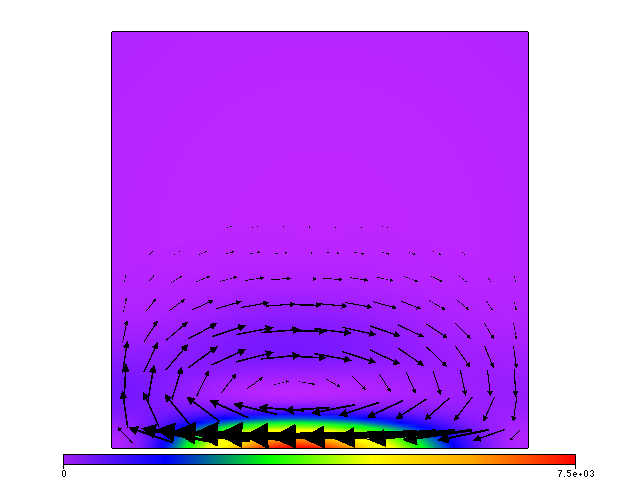

In [30]:
# lets check FEM solution
velmax = np.amax(velocityField.data[:])
vdotField = fn.math.dot(velocityField,velocityField)
velMag = plt.Figure()
velMag.Surface(vdotField, linearMesh)
velMag.VectorArrows(velocityField, linearMesh, lengthScale=0.1/velmax, arrowHeadSize=0.2 )
velMag.show()

#Figures

* These figures require live data to generate - to make figures from data output see "Tosi-analysis.ipynb"

In [31]:
#Grab depth function (assumes regular mesh)
sidewall = linearMesh.specialSets["MinI_VertexSet"]
depth = coordinate.evaluate(sidewall)[:,1]

In [32]:
#Setup data arrays (numpy arrays) depth averaged Temp, Viscosity, RMS vel., Stress 

#Temp
tempdata = np.reshape(temperatureField.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
tempmean = tempdata.mean(axis = 1)

#Visc

vfield = viscosityFn2.evaluate(linearMesh)
viscdata = np.reshape(vfield[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
viscmean = viscdata.mean(axis = 1)

#Rms
rms = np.sqrt(np.square(velocityField.data[:,0]) + np.square(velocityField.data[:,1]))
rmsdata = np.reshape(rms, (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
rmsmean = rmsdata.mean(axis = 1)

#Stress
rost = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
rostfield = rost.evaluate(linearMesh)
stressinv = 2*vfield[:]*rostfield[:]
stressdata = np.reshape(stressinv[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
stressmean = stressdata.mean(axis=1)

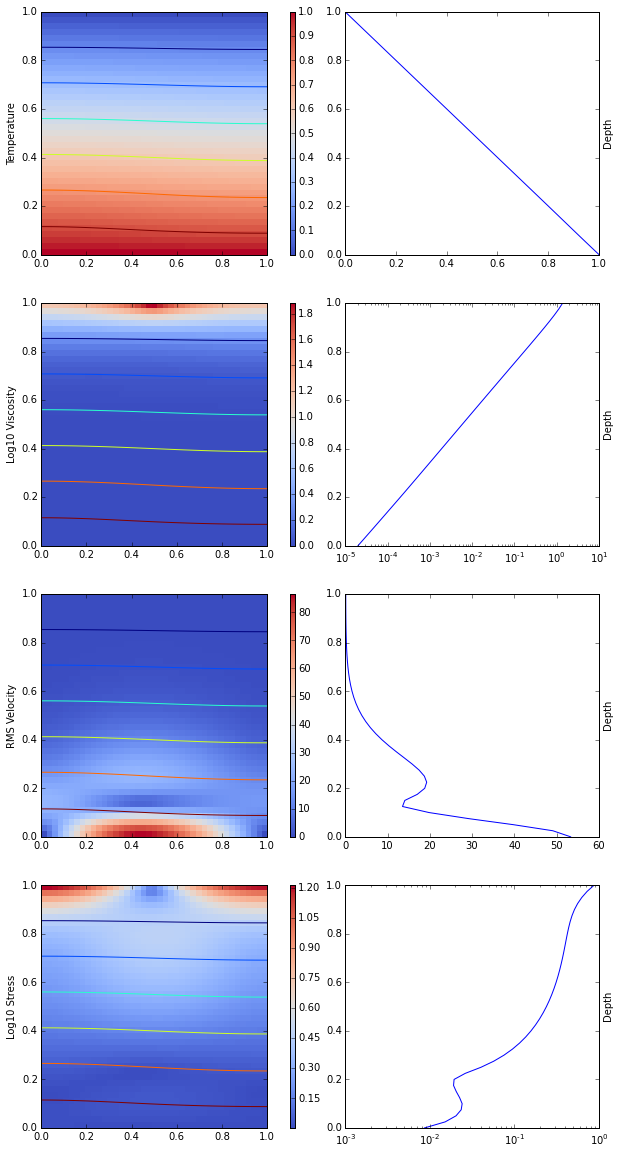

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

fig = pyplot.figure(figsize=(10,20))
ax = fig.add_subplot(421)
ax.set_ylabel('Temperature')
i = ax.imshow(np.flipud(tempdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.contour(image, extent=[0., 1., 0., 1.])
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)



ax = fig.add_subplot(422)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(tempmean[::-1],depth[::-1])

ax = fig.add_subplot(423)
i = ax.imshow(np.flipud(viscdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('Log10 Viscosity')
ax.contour(image, extent=[0., 1., 0., 1.])
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)


ax = fig.add_subplot(424)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(viscmean[::-1],depth[::-1])
ax.set_xscale('log')

ax = fig.add_subplot(425)
i = ax.imshow(np.flipud(rmsdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('RMS Velocity')
ax.contour(image, extent=[0., 1., 0., 1.])
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)

ax = fig.add_subplot(426)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(rmsmean[::-1],depth[::-1])

ax = fig.add_subplot(427)
i = ax.imshow(np.flipud(stressdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('Log10 Stress')
ax.contour(image, extent=[0., 1., 0., 1.])
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)

ax = fig.add_subplot(428)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(stressmean[::-1],depth[::-1])
ax.set_xscale('log')





Figure 1. Steady state snapshots of temperature, viscosity, RMS velocity, second invariant of the stress tensor, and (right column) corresponding laterally averaged profiles for Case 1 obtained with the code Underworld. 